In [1]:
import numpy as np
from torch_linear_svm import SGD_SVM_Torch, argp
from non_iid_split import split_img_noniid
import torch
from sklearn.metrics import accuracy_score
import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [2]:
def initialization(x,y,n_user = 50):
    model_set = dict()
    x_n_iid, y_n_iid = split_img_noniid(x, y)
    for i in range(n_user):
        model_set[i] = SGD_SVM_Torch(args=argp(epoch=1),lr_mode='Optimal')

    return model_set, x_n_iid,y_n_iid

data_preprocessed = pd.read_csv('/home/ericlong/PycharmProjects/pythonProject'
                                '/TKDE_data_figure/extracted_feature_table.csv')
x_train, y_train = np.array(data_preprocessed.iloc[:, 1:513]), np.array(data_preprocessed.iloc[:, 513])
PCA_decompose = PCA(n_components=100)


x_train_decompose = PCA_decompose.fit_transform(x_train)

MOD, x_non_iid, y_non_iid = initialization(x=x_train_decompose,y= y_train)
data_union = [x_non_iid,y_non_iid]
print('Datatype of x_non_iid',type(x_non_iid),len(x_non_iid))
print('Model type used:', MOD[0])

Datatype of x_non_iid <class 'dict'> 50
Model type used: <torch_linear_svm.SGD_SVM_Torch object at 0x7f64dc235bd0>


In [3]:
def client_update_collect(models:dict, distributed_data, weights_obtain=None, bias_obtain=None, epoch_index=None):
    # models contain all the model of clients, we conduct federated learning in one device. Every
    # model is class SGD_SVM_Torch
    # distributed_data stores (x,y) where x and y are shown in a decentralized manner.
    # weights_obtain denote the received weights from the central server after average
    n_user = len(models)
    if (type(weights_obtain) == type(None)) and (type(bias_obtain) == type(None)):
        print('Start from initialization')
        for i in range(n_user):
            # take string on i due to that we store the data in dictionary with key i.
            models[i].fit(x=distributed_data[0][str(i)],y=distributed_data[1][str(i)])
    else:
        print('Epoch update:', epoch_index)
        for i in range(n_user):
            models[i].learning_rate = 0.0001/epoch_index
            # if we take 'Optimal Rate' mode, a small change in epoch would not impact the result so much
            # so force the reduction of learning rate. Assume that 0.0001 is the lambda we set.
            models[i].fit(x=distributed_data[0][str(i)], y=distributed_data[1][str(i)], weights=weights_obtain,
                          bias = bias_obtain)
    return models

models_epoch1 = client_update_collect(models=MOD, distributed_data=data_union)

Start from initialization
Online learning mode activate, get weights and bias from historical knowledge
Optimal learning rate
Epoch:    1	loss:0.027167780680118957
Online learning mode activate, get weights and bias from historical knowledge
Optimal learning rate
Epoch:    1	loss:0.027110120120076086
Online learning mode activate, get weights and bias from historical knowledge
Optimal learning rate
Epoch:    1	loss:0.0268958988303394
Online learning mode activate, get weights and bias from historical knowledge
Optimal learning rate
Epoch:    1	loss:0.026446763361465037
Online learning mode activate, get weights and bias from historical knowledge
Optimal learning rate
Epoch:    1	loss:0.026232633416707805
Online learning mode activate, get weights and bias from historical knowledge
Optimal learning rate
Epoch:    1	loss:0.027020098286212525
Online learning mode activate, get weights and bias from historical knowledge
Optimal learning rate
Epoch:    1	loss:0.027318948481468795
Online lea

In [4]:
def evaluate(models, distributed_data):
    x_clients = distributed_data[0]
    y_clients = distributed_data[1]

    acc = list()

    for i in range(len(models)):
        pred = models[i].predict(x_new=x_clients[str(i)])
        acc.append(accuracy_score(y_true=y_clients[str(i)],y_pred=pred))

    return acc

acc_temp1 = evaluate(models=models_epoch1,distributed_data=data_union)
print('The classification of accuracy for the first epoch, by users:', acc_temp1)

The classification of accuracy for the first epoch, by users: [0.19653179190751446, 0.36574746008708275, 0.72782874617737, 0.23536895674300254, 0.4755077658303465, 0.32338308457711445, 0.856418918918919, 0.16557377049180327, 0.4334061135371179, 0.1008513425016372, 0.9367469879518072, 0.09477756286266925, 0.0859375, 0.11538461538461539, 0.8787234042553191, 0.3534994068801898, 0.24700854700854702, 0.5065243179122183, 0.6355140186915887, 0.9411764705882353, 0.6494992846924177, 0.5285118219749653, 0.5634588563458857, 0.3682795698924731, 0.11134307585247043, 0.13763440860215054, 0.4803804994054697, 0.08760545100584036, 0.3888888888888889, 0.521239954075775, 0.5408805031446541, 0.9369369369369369, 0.36860670194003525, 0.6992248062015504, 0.5312855517633674, 0.5282021151586369, 0.31322314049586775, 0.8269230769230769, 0.13469985358711567, 0.4693627450980392, 0.06339468302658487, 0.17566594672426206, 0.8027613412228797, 0.9372937293729373, 0.08505917159763314, 0.2522432701894317, 0.80869565217

In [5]:
def model_average(models, distributed_data):
    # the slice index 1 stands for y.
    n_client = [len(i) for i in distributed_data[1]]
    n = sum(n_client)
    weights = torch.zeros(size=models[0].weights.size())
    bias = torch.zeros(size=models[0].bias.size())

    for i in range(len(models)):
        weights += (n_client[i]/n)*models[i].weights
        bias += (n_client[i]/n)*models[i].bias

    return  weights, bias

weights, bias = model_average(models=models_epoch1, distributed_data=data_union)
models_epoch2 = client_update_collect(models=models_epoch1, distributed_data=data_union, weights_obtain=weights,
                                      bias_obtain=bias, epoch_index=2)
acc_temp2 = evaluate(models=models_epoch2,distributed_data=data_union)

Epoch update: 2
Obtain parameters from previous models
Online learning mode activate, get weights and bias from historical knowledge
Optimal learning rate
Epoch:    1	loss:0.022381079873080887
Online learning mode activate, get weights and bias from historical knowledge
Optimal learning rate
Epoch:    1	loss:0.021855738272384413
Online learning mode activate, get weights and bias from historical knowledge
Optimal learning rate
Epoch:    1	loss:0.02257413210379595
Online learning mode activate, get weights and bias from historical knowledge
Optimal learning rate
Epoch:    1	loss:0.021556151072586203
Online learning mode activate, get weights and bias from historical knowledge
Optimal learning rate
Epoch:    1	loss:0.021478593543258016
Online learning mode activate, get weights and bias from historical knowledge
Optimal learning rate
Epoch:    1	loss:0.022225838886692346
Online learning mode activate, get weights and bias from historical knowledge
Optimal learning rate
Epoch:    1	loss:0

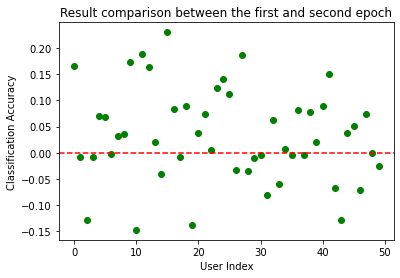

Mean of Accuracy changed from Epoch 1 to 2: 0.03270213307142762


In [6]:
diff_1_2 = np.array(acc_temp2)-np.array(acc_temp1)
plt.plot(range(50),diff_1_2, 'go')
plt.axhline(y=0, color='r', linestyle='--')
#plt.plot(range(50), acc_temp1, 'b+')
#plt.plot(range(50), acc_temp2, 'r+')
plt.title('Result comparison between the first and second epoch')
plt.xlabel('User Index')
plt.ylabel('Classification Accuracy')
plt.show()
print('Mean of Accuracy changed from Epoch 1 to 2:', np.mean(diff_1_2))

Online learning mode activate, get weights and bias from historical knowledge
Optimal learning rate
Epoch:    1	loss:0.006727180252649996
Epoch:    2	loss:0.005133337445936631
Epoch:    3	loss:0.004721245248703054
Epoch:    4	loss:0.004475263666856918
Epoch:    5	loss:0.004311552269005624
Online learning mode activate, get weights and bias from historical knowledge
Optimal learning rate
Epoch:    1	loss:0.006062292447588407
Epoch:    2	loss:0.0038590986475115644
Epoch:    3	loss:0.003377232865183323
Epoch:    4	loss:0.003137581887386332
Epoch:    5	loss:0.002987463644708041
Online learning mode activate, get weights and bias from historical knowledge
Optimal learning rate
Epoch:    1	loss:0.007125568595026898
Epoch:    2	loss:0.005987382187410294
Epoch:    3	loss:0.005848522934997017
Epoch:    4	loss:0.00571017056773344
Epoch:    5	loss:0.005573855663256254
Online learning mode activate, get weights and bias from historical knowledge
Optimal learning rate
Epoch:    1	loss:0.00719706409

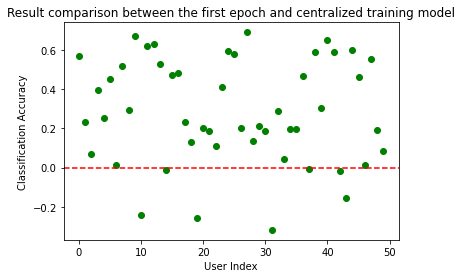

Mean of Accuracy changed from Epoch 1 to full central train: 0.28664189267477225


In [7]:
clf = SGD_SVM_Torch(argp(epoch=5),lr_mode='Optimal')
clf.fit(x=x_train_decompose, y=y_train)
model_full = dict()
for i in range(50):
    model_full[i] = clf
acc_full = evaluate(models= model_full, distributed_data = data_union)

diff_1_central_train = np.array(acc_full)-np.array(acc_temp1)
plt.plot(range(50),diff_1_central_train, 'go')
plt.axhline(y=0, color='r', linestyle='--')
#plt.plot(range(50), acc_temp1, 'b+')
#plt.plot(range(50), acc_temp2, 'r+')
plt.title('Result comparison between the first epoch and centralized training model')
plt.xlabel('User Index')
plt.ylabel('Classification Accuracy')
#plt.savefig('centralized_training.jpg')
plt.show()
print('Mean of Accuracy changed from Epoch 1 to full central train:', np.mean(diff_1_central_train))

In [ ]:
total_epoch = 100

# Initialization

model_former = MOD
weights = None
bias = None
data_use = data_union

for ep in range(1, total_epoch):
    model_latter = client_update_collect(models=model_former, distributed_data=data_use,
                                         weights_obtain=weights, bias_obtain=bias,epoch_index=1)
    acc = evaluate(model_latter,distributed_data=data_use)
    print(np.mean(acc))
    weights, bias = model_average(model_latter, distributed_data=data_use)
    model_former = client_update_collect(model_latter, distributed_data=data_use,
                                         weights_obtain=weights, bias_obtain=bias, epoch_index= 1)

diff = np.array(acc)-np.array(acc_temp1)





Start from initialization
Online learning mode activate, get weights and bias from historical knowledge
Optimal learning rate
Epoch:    1	loss:0.02714520520557558
Online learning mode activate, get weights and bias from historical knowledge
Optimal learning rate
Epoch:    1	loss:0.027121725109960304
Online learning mode activate, get weights and bias from historical knowledge
Optimal learning rate
Epoch:    1	loss:0.026885694980276802
Online learning mode activate, get weights and bias from historical knowledge
Optimal learning rate
Epoch:    1	loss:0.02637066532766199
Online learning mode activate, get weights and bias from historical knowledge
Optimal learning rate
Epoch:    1	loss:0.02625397075979696
Online learning mode activate, get weights and bias from historical knowledge
Optimal learning rate
Epoch:    1	loss:0.027125065424883296
Online learning mode activate, get weights and bias from historical knowledge
Optimal learning rate
Epoch:    1	loss:0.027312722853842498
Online lear

In [ ]:
plt.plot(range(50),diff, 'go')
plt.axhline(y=0, color='r', linestyle='--')
#plt.plot(range(50), acc_temp1, 'b+')
#plt.plot(range(50), acc_temp2, 'r+')
plt.title('Result comparison between the first epoch and decentralized training model')
plt.xlabel('User Index')
plt.ylabel('Classification Accuracy')
#plt.savefig('decentralized_training_CM100.jpg')
plt.show()
print('Mean of accuracy increased:', np.mean(diff))

